In [1]:
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import os
import urllib.request
import tarfile

# Dataset handling
import src.utils.lfw_dataset_handler as lfw


In [7]:
"""
Módulo de configuración principal
--------------------------------
Define los hiperparámetros clave y configuraciones del modelo:
- latent_dim: Dimensión del vector de ruido de entrada al generador
- image_size: Tamaño de las imágenes generadas
- batch_size: Número de imágenes procesadas en cada iteración
- lr: Learning rate para los optimizadores
- betas: Parámetros de momentum para Adam
- sample_dir: Directorio para guardar las imágenes generadas
"""
CONFIG = {
    'latent_dim': 100,
    'image_size': 64,  # Tamaño optimizado para GAN
    'channels': 3,
    'batch_size': 64,
    'lr': 0.0002,
    'betas': (0.5, 0.999),
    'epochs': 210,
    'sample_interval': 5,
    'base_dir': './data',
    'sample_dir': './generated_samples',
    'model_dir': './saved_models'
}

# Crear directorios necesarios
for dir_path in [CONFIG['sample_dir'], CONFIG['model_dir']]:
    os.makedirs(dir_path, exist_ok=True)


In [3]:
# def setup_lfw_dataset(base_dir='./data', download=True):
#     """
#     Configura el dataset LFW.
#     """
#     # URLs y rutas
#     LFW_URL = "http://vis-www.cs.umass.edu/lfw/lfw.tgz"
#     data_dir = os.path.join(base_dir, 'lfw')
    
#     # Crear directorio base si no existe
#     if not os.path.exists(base_dir):
#         os.makedirs(base_dir)
    
#     # Verificar si el dataset ya existe
#     if not os.path.exists(data_dir) and download:
#         print("Descargando dataset LFW...")
#         tgz_path = os.path.join(base_dir, 'lfw.tgz')
#         urllib.request.urlretrieve(LFW_URL, tgz_path)
        
#         print("Extrayendo archivos...")
#         with tarfile.open(tgz_path, 'r:gz') as tar:
#             tar.extractall(path=base_dir)
#         os.remove(tgz_path)
#         print("Dataset LFW preparado correctamente.")
#     elif not os.path.exists(data_dir) and not download:
#         raise RuntimeError("Dataset no encontrado. Establece download=True para descargarlo.")
#     else:
#         print("Dataset LFW encontrado en disco.")
    
#     return data_dir

# def get_lfw_loaders(batch_size=32, base_dir='./data', download=True):
#     """
#     Crea los dataloaders para LFW.
#     """
#     # Configurar el dataset
#     data_dir = setup_lfw_dataset(base_dir, download)
    
#     # Definir transformaciones
#     transform = transforms.Compose([
#         transforms.Resize((128, 128)),
#         transforms.ToTensor(),
#     ])
    
#     # Crear dataset usando ImageFolder
#     dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)
    
#     # Dividir dataset
#     total_size = len(dataset)
#     train_size = int(0.8 * total_size)
#     val_size = int(0.1 * total_size)
#     test_size = total_size - train_size - val_size
    
#     train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
#         dataset, [train_size, val_size, test_size]
#     )
    
#     # Crear dataloaders
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=batch_size,
#         shuffle=True,
#         num_workers=4 if torch.cuda.is_available() else 0,
#         pin_memory=torch.cuda.is_available()
#     )
    
#     val_loader = DataLoader(
#         val_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=4 if torch.cuda.is_available() else 0,
#         pin_memory=torch.cuda.is_available()
#     )
    
#     test_loader = DataLoader(
#         test_dataset,
#         batch_size=batch_size,
#         shuffle=False,
#         num_workers=4 if torch.cuda.is_available() else 0,
#         pin_memory=torch.cuda.is_available()
#     )
    
#     return train_loader, val_loader, test_loader
"""
Modificación de las transformaciones para optimizar el dataset
"""
def get_transforms():
    return transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

"""
Función para adaptar los dataloaders proporcionados
"""
def setup_data():
    # Usar las funciones proporcionadas pero con nuestras transformaciones
    train_loader, val_loader, test_loader = lfw.get_data_loaders(
        batch_size=CONFIG['batch_size'],
        base_dir=CONFIG['base_dir'],
        download=True,
        transform=get_transforms()
    )
    
    # # Modificar las transformaciones de los datasets
    # custom_transform = get_transforms()
    
    # # Actualizar transformaciones en los datasets
    # for loader in [train_loader, val_loader, test_loader]:
    #     loader.dataset.dataset.transform = custom_transform
        
    return train_loader, val_loader, test_loader


In [4]:
"""
Sistema de monitoreo mejorado para seguimiento del entrenamiento
"""
class TrainingMonitor:
    def __init__(self, save_dir):
        self.g_losses = []
        self.d_losses = []
        self.val_losses = []
        self.save_dir = save_dir
        
    def update(self, g_loss, d_loss, val_loss=None):
        self.g_losses.append(g_loss)
        self.d_losses.append(d_loss)
        if val_loss is not None:
            self.val_losses.append(val_loss)
            
    def save_samples(self, generator, fixed_noise, epoch):
        """Guarda muestras del generador"""
        with torch.no_grad():
            fake_images = generator(fixed_noise)
            vutils.save_image(
                fake_images,
                f'{self.save_dir}/epoch_{epoch}.png',
                normalize=True,
                nrow=4
            )
            
    def plot_progress(self):
        """Genera gráfica de progreso del entrenamiento"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.g_losses, label='Generator Loss', alpha=0.7)
        plt.plot(self.d_losses, label='Discriminator Loss', alpha=0.7)
        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss', alpha=0.7)
        plt.legend()
        plt.title('Training Progress')
        plt.savefig(f'{self.save_dir}/training_progress.png')
        plt.close()

In [5]:

"""
Módulo Discriminador
-------------------
Arquitectura convolucional que evalúa si una imagen es real o generada:
- Entrada: Imágenes RGB 64x64
- Capas intermedias: Convoluciones con stride=2 que reducen dimensionalidad
- BatchNorm y LeakyReLU para estabilidad y no-linealidad
- Salida: Probabilidad de que la imagen sea real (0-1)
"""
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        def discriminator_block(in_channels, out_channels, normalize=True):
            """Bloque básico del discriminador"""
            layers = [nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(CONFIG['channels'], 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.Conv2d(512, 1, 4, stride=1, padding=0),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x).view(-1, 1).squeeze(1)

"""
Módulo Generador
---------------
Arquitectura que transforma ruido aleatorio en imágenes:
- Entrada: Vector de ruido latent_dim-dimensional
- Capas intermedias: Convoluciones transpuestas que aumentan dimensionalidad
- BatchNorm y ReLU para estabilidad y no-linealidad
- Salida: Imágenes RGB 64x64 con valores en [-1,1]
"""
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def generator_block(in_channels, out_channels, normalize=True):
            """Bloque básico del generador"""
            layers = [nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            return layers

        self.model = nn.Sequential(
            # Primera capa - proyección y reshape del vector latente
            nn.ConvTranspose2d(CONFIG['latent_dim'], 512, 4, stride=1, padding=0),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # Capas de upsampling
            *generator_block(512, 256),
            *generator_block(256, 128),
            *generator_block(128, 64),
            # Capa final
            nn.ConvTranspose2d(64, CONFIG['channels'], 4, stride=2, padding=1),
            nn.Tanh()
        )
        
    def forward(self, z):
        z = z.view(-1, CONFIG['latent_dim'], 1, 1)
        return self.model(z)


In [6]:
def train_gan(train_loader, val_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Usando dispositivo: {device}")
    
    # Inicializar modelos
    D = Discriminator().to(device)
    G = Generator().to(device)

    # Inicializar optimizadores y función de pérdida    
    criterion = nn.BCELoss()
    d_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
    
    # Monitor y ruido fijo para muestras
    monitor = TrainingMonitor(CONFIG['sample_dir'])
    fixed_noise = torch.randn(16, CONFIG['latent_dim'], device=device)
    
    print("Iniciando entrenamiento...")
    for epoch in range(CONFIG['epochs']):
        G.train()
        D.train()
        
        d_epoch_loss = 0
        g_epoch_loss = 0
        
        for batch_idx, (real_images, _) in enumerate(train_loader):
            real_images = real_images.to(device)
            batch_size = real_images.size(0)
            
            # Labels para el entrenamiento
            real_label = torch.ones(batch_size, device=device)
            fake_label = torch.zeros(batch_size, device=device)
            
            # Entrenar Discriminador
            d_optimizer.zero_grad()
            output_real = D(real_images)
            d_loss_real = criterion(output_real, real_label)
            
            noise = torch.randn(batch_size, CONFIG['latent_dim'], device=device)
            fake_images = G(noise)
            output_fake = D(fake_images.detach())
            d_loss_fake = criterion(output_fake, fake_label)
            
            d_loss = d_loss_real + d_loss_fake
            d_loss.backward()
            d_optimizer.step()
            
            # Entrenar Generador
            g_optimizer.zero_grad()
            output_fake = D(fake_images)
            g_loss = criterion(output_fake, real_label)
            g_loss.backward()
            g_optimizer.step()
            
            # Actualizar pérdidas
            d_epoch_loss += d_loss.item()
            g_epoch_loss += g_loss.item()
            
            if batch_idx % 100 == 0:
                print(f'[Epoch {epoch}/{CONFIG["epochs"]}] '
                      f'[Batch {batch_idx}/{len(train_loader)}] '
                      f'D_loss: {d_loss.item():.4f} '
                      f'G_loss: {g_loss.item():.4f}')
        
        # Calcular pérdida de validación
        val_loss = 0
        D.eval()
        with torch.no_grad():
            for val_images, _ in val_loader:
                val_images = val_images.to(device)
                val_output = D(val_images)
                val_loss += criterion(val_output, torch.ones_like(val_output)).item()
        val_loss /= len(val_loader)
        
        # Actualizar monitor
        monitor.update(
            g_epoch_loss/len(train_loader),
            d_epoch_loss/len(train_loader),
            val_loss
        )
        
        # Guardar muestras y progreso
        if epoch % CONFIG['sample_interval'] == 0:
            monitor.save_samples(G, fixed_noise, epoch)
            monitor.plot_progress()
            
        # Guardar checkpoint
        if epoch % 50 == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': G.state_dict(),
                'discriminator_state_dict': D.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
            }, f'{CONFIG["model_dir"]}/checkpoint_epoch_{epoch}.pt')
    
    return G, D, monitor

In [8]:
# Preparar datos y entrenar
print("Preparando dataset...")
train_loader, val_loader, test_loader = setup_data()

print("Iniciando entrenamiento...")
G, D, monitor = train_gan(train_loader, val_loader)

# Guardar modelo final
torch.save(G.state_dict(), f'{CONFIG["model_dir"]}/generator_final.pt')
torch.save(D.state_dict(), f'{CONFIG["model_dir"]}/discriminator_final.pt')
monitor.plot_progress()

print("Entrenamiento completado.")

Preparando dataset...
Dataset lfw encontrado en disco.
Iniciando entrenamiento...
Usando dispositivo: cuda
Iniciando entrenamiento...
[Epoch 0/210] [Batch 0/166] D_loss: 1.4048 G_loss: 2.7763
[Epoch 0/210] [Batch 100/166] D_loss: 1.9741 G_loss: 12.4433
[Epoch 1/210] [Batch 0/166] D_loss: 0.2429 G_loss: 3.4172
[Epoch 1/210] [Batch 100/166] D_loss: 0.2820 G_loss: 3.6449
[Epoch 2/210] [Batch 0/166] D_loss: 1.0747 G_loss: 5.8156
[Epoch 2/210] [Batch 100/166] D_loss: 0.9789 G_loss: 1.1140
[Epoch 3/210] [Batch 0/166] D_loss: 0.9817 G_loss: 5.5208
[Epoch 3/210] [Batch 100/166] D_loss: 0.5488 G_loss: 3.0640
[Epoch 4/210] [Batch 0/166] D_loss: 0.9268 G_loss: 6.1080
[Epoch 4/210] [Batch 100/166] D_loss: 0.7018 G_loss: 3.5667
[Epoch 5/210] [Batch 0/166] D_loss: 0.5702 G_loss: 2.8276
[Epoch 5/210] [Batch 100/166] D_loss: 1.0966 G_loss: 5.8741
[Epoch 6/210] [Batch 0/166] D_loss: 0.5929 G_loss: 2.3711
[Epoch 6/210] [Batch 100/166] D_loss: 0.5100 G_loss: 3.7106
[Epoch 7/210] [Batch 0/166] D_loss: 1.2

KeyboardInterrupt: 

/tmp/ipykernel_5051/2552478982.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.generator.load_state_dict(torch.load(generator_path))


Generando resultados...


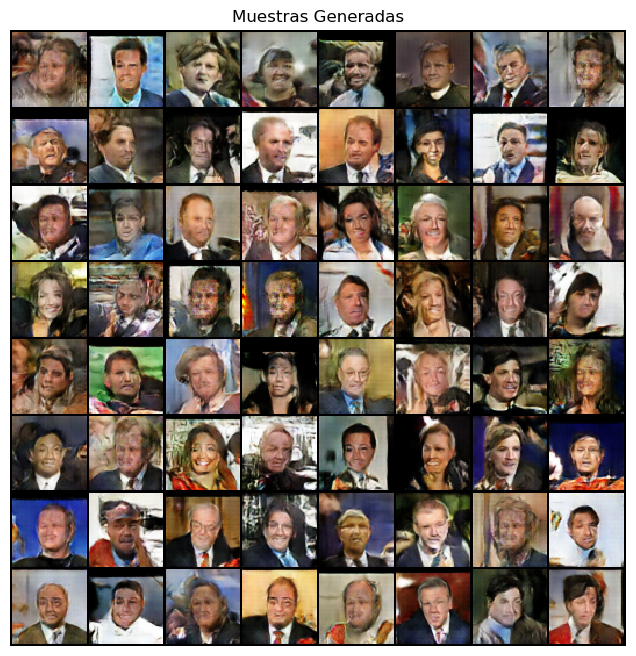

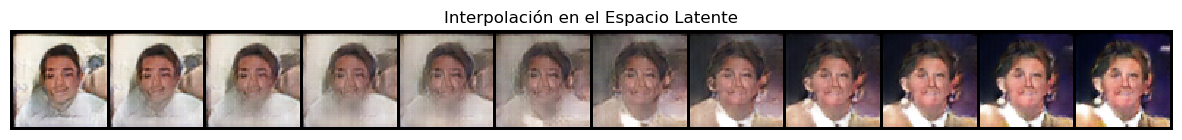

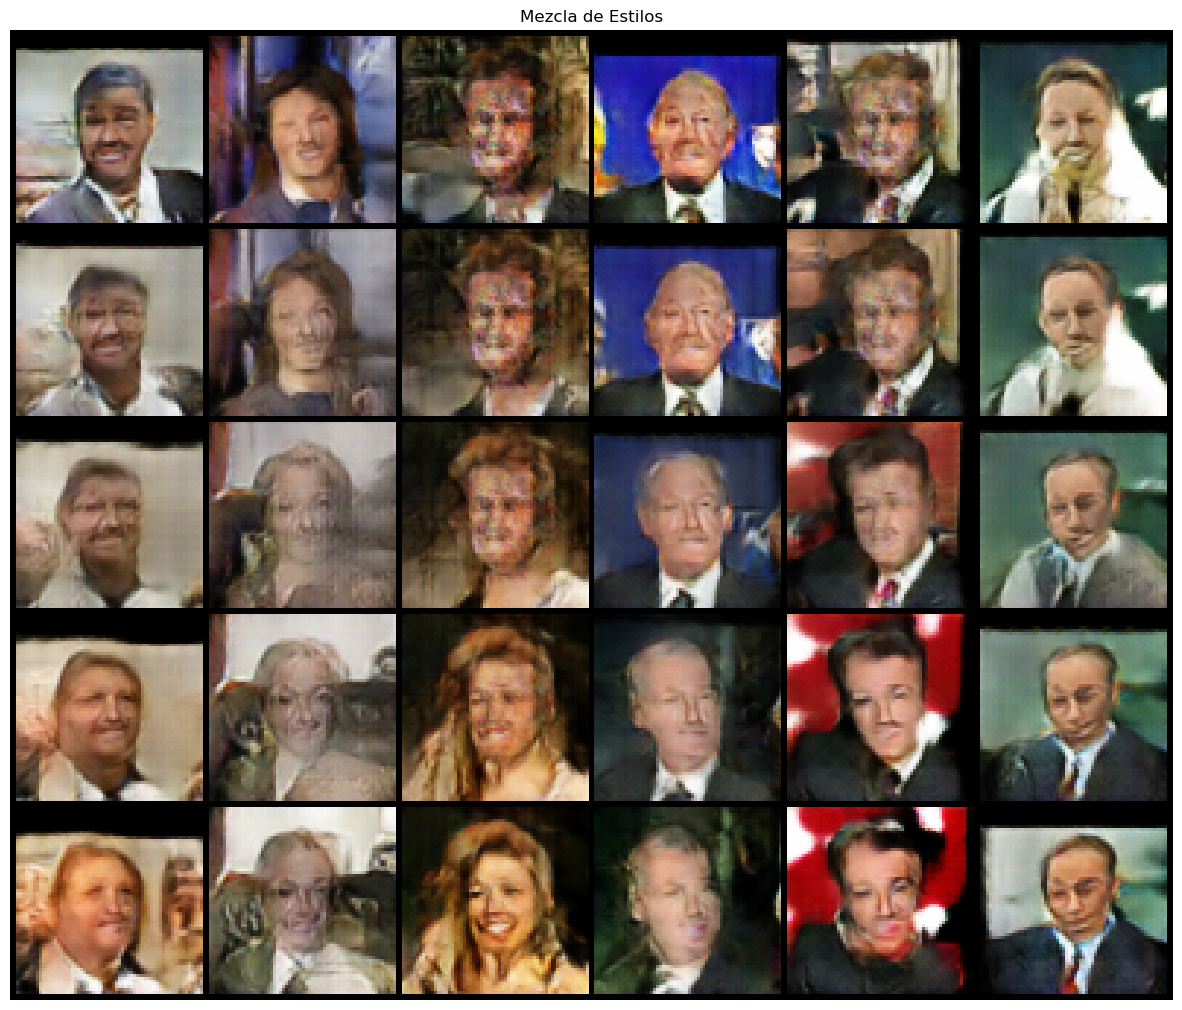

Evaluación completada. Resultados guardados en: ./evaluation_results
Generando muestras aleatorias...


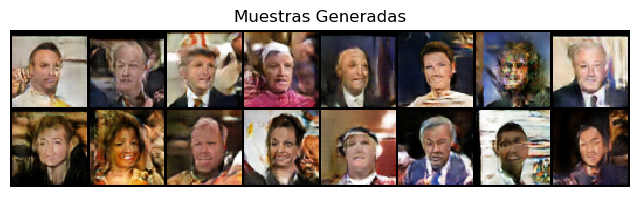


Generando interpolación en espacio latente...


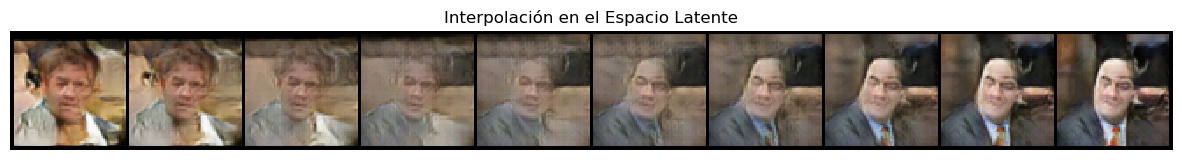


Generando mezclas de estilo...


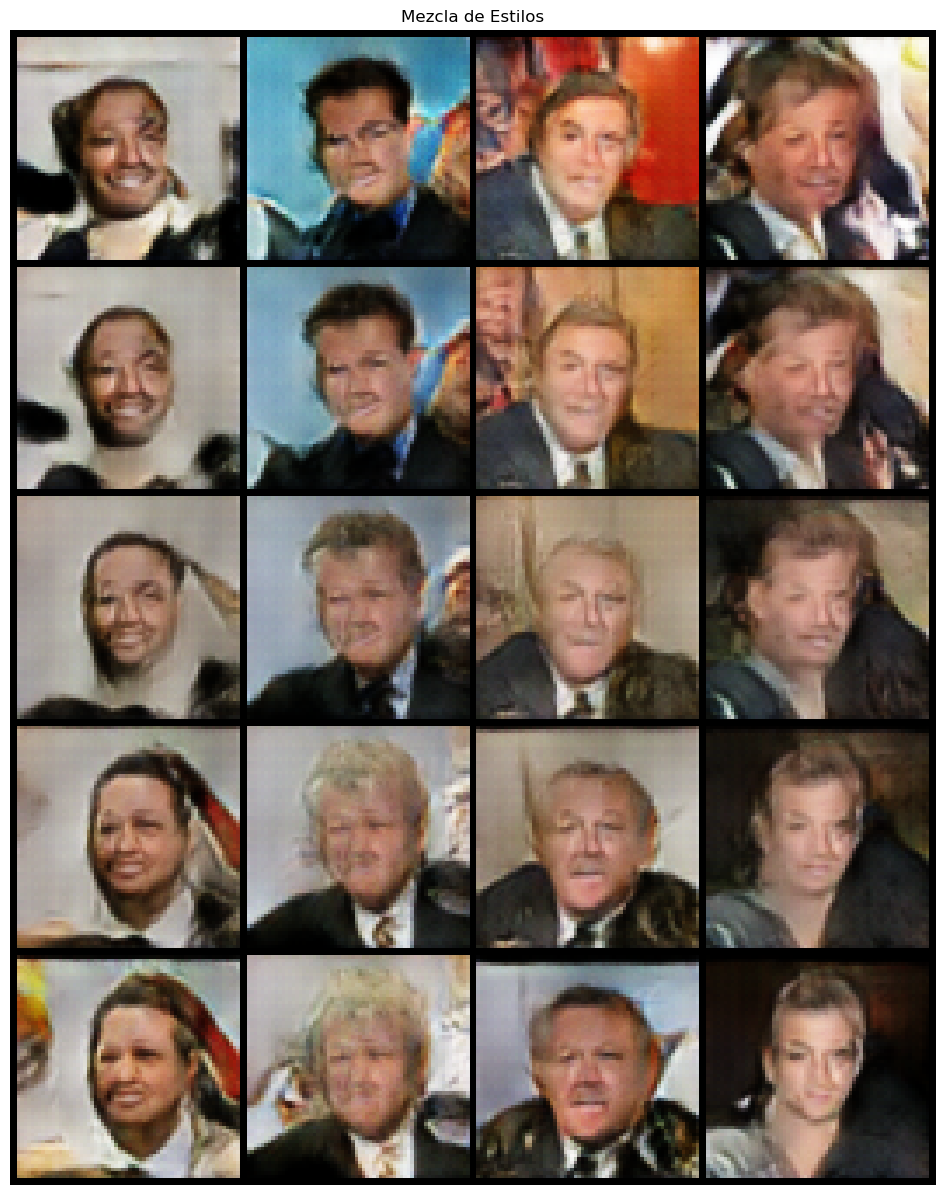

In [15]:
import torch
import torch.nn as nn
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

class ModelEvaluator:
    """
    Clase para evaluar y visualizar resultados del GAN
    """
    def __init__(self, generator_path, latent_dim=100, image_size=64):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.latent_dim = latent_dim
        self.image_size = image_size
        
        # Cargar generador
        self.generator = Generator().to(self.device)
        self.generator.load_state_dict(torch.load(generator_path))
        self.generator.eval()
        
    def generate_samples(self, num_samples=16, show=True):
        """
        Genera y muestra muestras aleatorias
        """
        with torch.no_grad():
            # Generar ruido aleatorio
            noise = torch.randn(num_samples, self.latent_dim, device=self.device)
            fake_images = self.generator(noise)
            
            # Convertir imágenes para visualización
            img_grid = vutils.make_grid(fake_images, padding=2, normalize=True)
            img_grid = img_grid.cpu().numpy().transpose((1, 2, 0))
            
            if show:
                plt.figure(figsize=(8, 8))
                plt.axis("off")
                plt.title("Muestras Generadas")
                plt.imshow(img_grid)
                plt.show()
            
            return fake_images
    
    def interpolate_latent_space(self, num_steps=10):
        """
        Genera interpolación entre dos puntos en el espacio latente
        """
        with torch.no_grad():
            # Generar dos vectores latentes aleatorios
            z1 = torch.randn(1, self.latent_dim, device=self.device)
            z2 = torch.randn(1, self.latent_dim, device=self.device)
            
            # Crear interpolaciones
            alphas = np.linspace(0, 1, num_steps)
            interpolated_images = []
            
            for alpha in alphas:
                z_interp = z1 * (1 - alpha) + z2 * alpha
                fake_image = self.generator(z_interp)
                interpolated_images.append(fake_image)
            
            # Concatenar y mostrar resultados
            interpolated_images = torch.cat(interpolated_images, dim=0)
            img_grid = vutils.make_grid(interpolated_images, nrow=num_steps, padding=2, normalize=True)
            img_grid = img_grid.cpu().numpy().transpose((1, 2, 0))
            
            plt.figure(figsize=(15, 4))
            plt.axis("off")
            plt.title("Interpolación en el Espacio Latente")
            plt.imshow(img_grid)
            plt.show()
            
            return interpolated_images
    
    def style_mixing(self, num_samples=4):
        """
        Genera mezclas de estilo entre diferentes muestras
        """
        with torch.no_grad():
            # Generar vectores latentes
            z1 = torch.randn(num_samples, self.latent_dim, device=self.device)
            z2 = torch.randn(num_samples, self.latent_dim, device=self.device)
            
            # Crear matriz de mezclas
            mixed_images = []
            
            # Agregar imágenes originales
            mixed_images.append(self.generator(z1))
            
            # Crear mezclas con diferentes proporciones
            alphas = [0.25, 0.5, 0.75]
            for alpha in alphas:
                z_mixed = z1 * (1 - alpha) + z2 * alpha
                mixed_images.append(self.generator(z_mixed))
            
            # Agregar segundas imágenes originales
            mixed_images.append(self.generator(z2))
            
            # Mostrar resultados
            mixed_images = torch.cat(mixed_images, dim=0)
            img_grid = vutils.make_grid(mixed_images, nrow=num_samples, padding=2, normalize=True)
            img_grid = img_grid.cpu().numpy().transpose((1, 2, 0))
            
            plt.figure(figsize=(15, 15))
            plt.axis("off")
            plt.title("Mezcla de Estilos")
            plt.imshow(img_grid)
            plt.show()
            
            return mixed_images
    
    def save_image_grid(self, images, path, nrow=8):
        """
        Guarda una cuadrícula de imágenes en disco
        """
        vutils.save_image(images, path, nrow=nrow, padding=2, normalize=True)

def evaluate_model(generator_path, output_dir='./evaluation_results'):
    """
    Realiza una evaluación completa del modelo
    """
    # Crear directorio para resultados
    os.makedirs(output_dir, exist_ok=True)
    
    # Inicializar evaluador
    evaluator = ModelEvaluator(generator_path)
    
    print("Generando resultados...")
    
    # 1. Generar y guardar muestras aleatorias
    samples = evaluator.generate_samples(num_samples=64)
    evaluator.save_image_grid(
        samples,
        f'{output_dir}/random_samples.png',
        nrow=8
    )
    
    # 2. Generar y guardar interpolaciones
    interpolations = evaluator.interpolate_latent_space(num_steps=12)
    evaluator.save_image_grid(
        interpolations,
        f'{output_dir}/interpolations.png',
        nrow=12
    )
    
    # 3. Generar y guardar mezclas de estilo
    style_mixes = evaluator.style_mixing(num_samples=6)
    evaluator.save_image_grid(
        style_mixes,
        f'{output_dir}/style_mixing.png',
        nrow=6
    )
    
    print("Evaluación completada. Resultados guardados en:", output_dir)

# Ejemplo de uso
if __name__ == "__main__":
    # Ruta al modelo entrenado
    generator_path = './saved_models/generator_final.pt'
    
    # Realizar evaluación
    evaluate_model(generator_path)
    
    # Para evaluación interactiva
    evaluator = ModelEvaluator(generator_path)
    
    # Generar diferentes visualizaciones
    print("Generando muestras aleatorias...")
    evaluator.generate_samples(num_samples=16)
    
    print("\nGenerando interpolación en espacio latente...")
    evaluator.interpolate_latent_space(num_steps=10)
    
    print("\nGenerando mezclas de estilo...")
    evaluator.style_mixing(num_samples=4)